In [1]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import albumentations as A
import cv2
import numpy as np
import os
import glob as glob
from xml.etree import ElementTree as et
from torch.utils.data import Dataset, DataLoader

BATCH_SIZE = 2 # increase / decrease according to GPU memeory
RESIZE_TO = 512 # resize the image for training and transforms
NUM_EPOCHS = 5 # number of epochs to train for

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

TRAIN_DIR =r'C:\jonas\pytorch\20211025_Custom_Object_Detection_using_PyTorch_Faster_RCNN\Microcontroller Detection\train'
VALID_DIR = r'C:\jonas\pytorch\20211025_Custom_Object_Detection_using_PyTorch_Faster_RCNN\Microcontroller Detection\test'

CLASSES = [
    'background', 'Arduino_Nano', 'ESP8266', 'Raspberry_Pi_3', 'Heltec_ESP32_Lora'
]
NUM_CLASSES = 5


OUT_DIR = r'C:\jonas\pytorch\20211025_Custom_Object_Detection_using_PyTorch_Faster_RCNN\custom_object_detecting/outputs'
SAVE_PLOTS_EPOCH = 2 # save loss plots after these many epochs
SAVE_MODEL_EPOCH = 2 # save model after these many epochs


In [2]:

def create_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
    return model


In [3]:

from albumentations.pytorch import ToTensorV2


def collate_fn(batch):
    """
    To handle the data loading as different images may have different number 
    of objects and to handle varying size tensors as well.
    """
    return tuple(zip(*batch))

# define the training tranforms
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        A.RandomRotate90(0.5),
        A.MotionBlur(p=0.2),
        A.MedianBlur(blur_limit=3, p=0.1),
        A.Blur(blur_limit=3, p=0.1),
        ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc',
        'label_fields': ['labels']
    })

# define the validation transforms
def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc', 
        'label_fields': ['labels']
    })


In [4]:
# the dataset class
class MicrocontrollerDataset(Dataset):
    def __init__(self, dir_path, width, height, classes, transforms=None):
        self.transforms = transforms
        self.dir_path = dir_path
        self.height = height
        self.width = width
        self.classes = classes
        
        # get all the image paths in sorted order
        self.image_paths = glob.glob(f"{self.dir_path}/*.jpg")
        self.all_images = [image_path.split('/')[-1] for image_path in self.image_paths]
        self.all_images = sorted(self.all_images)

    def __getitem__(self, idx):
        # capture the image name and the full image path
        image_name = self.all_images[idx]
        image_path = os.path.join(self.dir_path, image_name)
        
        # read the image
        image = cv2.imread(image_path)
        # convert BGR to RGB color format
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image_resized = cv2.resize(image, (self.width, self.height))
        image_resized /= 255.0
        
        # capture the corresponding XML file for getting the annotations
        annot_filename = image_name[:-4] + '.xml'
        annot_file_path = os.path.join(self.dir_path, annot_filename)
        
        boxes = []
        labels = []
        tree = et.parse(annot_file_path)
        root = tree.getroot()
        
        # get the height and width of the image
        image_width = image.shape[1]
        image_height = image.shape[0]
        
        # box coordinates for xml files are extracted and corrected for image size given
        for member in root.findall('object'):
            # map the current object name to `classes` list to get...
            # ... the label index and append to `labels` list
            labels.append(self.classes.index(member.find('name').text))
            
            # xmin = left corner x-coordinates
            xmin = int(member.find('bndbox').find('xmin').text)
            # xmax = right corner x-coordinates
            xmax = int(member.find('bndbox').find('xmax').text)
            # ymin = left corner y-coordinates
            ymin = int(member.find('bndbox').find('ymin').text)
            # ymax = right corner y-coordinates
            ymax = int(member.find('bndbox').find('ymax').text)
            
            # resize the bounding boxes according to the...
            # ... desired `width`, `height`
            xmin_final = (xmin/image_width)*self.width
            xmax_final = (xmax/image_width)*self.width
            ymin_final = (ymin/image_height)*self.height
            yamx_final = (ymax/image_height)*self.height
            
            boxes.append([xmin_final, ymin_final, xmax_final, yamx_final])
        
        # bounding box to tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # area of the bounding boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # no crowd instances
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        # labels to tensor
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # prepare the final `target` dictionary
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        image_id = torch.tensor([idx])
        target["image_id"] = image_id

        # apply the image transforms
        if self.transforms:
            sample = self.transforms(image = image_resized,
                                     bboxes = target['boxes'],
                                     labels = labels)
            image_resized = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
            
        return image_resized, target

    def __len__(self):
        return len(self.all_images)

# prepare the final datasets and data loaders
#不对train_dataset引用时，此时只是赋值对象，并不会执行MicroncontrollerDataset函数
train_dataset = MicrocontrollerDataset(TRAIN_DIR, RESIZE_TO, RESIZE_TO, CLASSES, get_train_transform())
valid_dataset = MicrocontrollerDataset(VALID_DIR, RESIZE_TO, RESIZE_TO, CLASSES, get_valid_transform())
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)
valid_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)




In [5]:
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import time

plt.style.use('ggplot')

# function for running training iterations
def train(train_data_loader, model):
    print('Training')
    global train_itr
    global train_loss_list
    
     # initialize tqdm progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))
    
    for i, data in enumerate(prog_bar):
        optimizer.zero_grad()
        images, targets = data       
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        train_loss_list.append(loss_value)
        losses.backward()
        optimizer.step()
        train_itr += 1
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return train_loss_list

# function for running validation iterations
def validate(valid_data_loader, model):
    print('Validating')
    global val_itr
    global val_loss_list
    prog_bar = tqdm(valid_data_loader, total=len(valid_data_loader))  
    for i, data in enumerate(prog_bar):
        images, targets = data        
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]       
        with torch.no_grad():
            loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        val_loss_list.append(loss_value)
        val_itr += 1
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return val_loss_list

if __name__ == '__main__':
    # initialize the model and move to the computation device
    model = create_model(num_classes=NUM_CLASSES)
    model = model.to(DEVICE)
    # get the model parameters
    params = [p for p in model.parameters() if p.requires_grad]
    # define the optimizer
    optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)

    # initialize the Averager class
    # train_loss_hist = Averager()
    # val_loss_hist = Averager()
    train_itr = 1
    val_itr = 1
    # train and validation loss lists to store loss values of all...
    # ... iterations till ena and plot graphs for all iterations
    train_loss_list = []
    val_loss_list = []

    # name to save the trained model with
    MODEL_NAME = 'model'


    # start the training epochs
    for epoch in range(NUM_EPOCHS):
        print(f"\nEPOCH {epoch+1} of {NUM_EPOCHS}")

        # reset the training and validation loss histories for the current epoch
        # train_loss_hist.reset()   #设置为0
        # val_loss_hist.reset()

        # create two subplots, one for each, training and validation
        figure_1, train_ax = plt.subplots()
        figure_2, valid_ax = plt.subplots()

        # start timer and carry out training and validation
        start = time.time()
        train_loss = train(train_loader, model)
        val_loss = validate(valid_loader, model)


#         if (epoch+1) % SAVE_MODEL_EPOCH == 0: # save model after every n epochs
#             torch.save(model.state_dict(), f"{OUT_DIR}/model{epoch+1}.pth")
#             print('SAVING MODEL COMPLETE...\n')
        
#         if (epoch+1) % SAVE_PLOTS_EPOCH == 0: # save loss plots after n epochs
#             train_ax.plot(train_loss, color='blue')
#             train_ax.set_xlabel('iterations')
#             train_ax.set_ylabel('train loss')
#             valid_ax.plot(val_loss, color='red')
#             valid_ax.set_xlabel('iterations')
#             valid_ax.set_ylabel('validation loss')
#             figure_1.savefig(f"{OUT_DIR}/train_loss_{epoch+1}.png")
#             figure_2.savefig(f"{OUT_DIR}/valid_loss_{epoch+1}.png")
#             print('SAVING PLOTS COMPLETE...')
        
#         if (epoch+1) == NUM_EPOCHS: # save loss plots and model once at the end
#             train_ax.plot(train_loss, color='blue')
#             train_ax.set_xlabel('iterations')
#             train_ax.set_ylabel('train loss')
#             valid_ax.plot(val_loss, color='red')
#             valid_ax.set_xlabel('iterations')
#             valid_ax.set_ylabel('validation loss')
#             figure_1.savefig(f"{OUT_DIR}/train_loss_{epoch+1}.png")
#             figure_2.savefig(f"{OUT_DIR}/valid_loss_{epoch+1}.png")

#             torch.save(model.state_dict(), f"{OUT_DIR}/model{epoch+1}.pth")
        
        plt.close('all')
        # sleep for 5 seconds after each epoch
        time.sleep(5)
#保存最终模型
torch.save(model.state_dict(), f"{OUT_DIR}/model{epoch+1}.pth")


EPOCH 1 of 5
Training


  0%|          | 0/71 [00:00<?, ?it/s]

C:\Python39\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Validating


  0%|          | 0/4 [00:00<?, ?it/s]


EPOCH 2 of 5
Training


  0%|          | 0/71 [00:00<?, ?it/s]

Validating


  0%|          | 0/4 [00:00<?, ?it/s]


EPOCH 3 of 5
Training


  0%|          | 0/71 [00:00<?, ?it/s]

Validating


  0%|          | 0/4 [00:00<?, ?it/s]


EPOCH 4 of 5
Training


  0%|          | 0/71 [00:00<?, ?it/s]

Validating


  0%|          | 0/4 [00:00<?, ?it/s]


EPOCH 5 of 5
Training


  0%|          | 0/71 [00:00<?, ?it/s]

Validating


  0%|          | 0/4 [00:00<?, ?it/s]

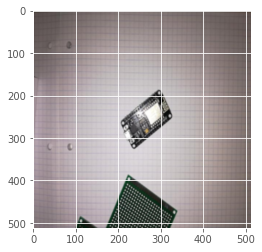

In [6]:
im=list(train_dataset)[2][0]
im=im.permute(1,2,0)
import matplotlib.pyplot as plt
plt.imshow(im)

In [7]:
#消除GPU内存
import gc
gc.collect()
torch.cuda.empty_cache()

In [8]:
import torch
import cv2 as cv
import torchvision.transforms as T
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import convert_image_dtype
img = cv.imread(r'C:\jonas\pytorch\20211025_Custom_Object_Detection_using_PyTorch_Faster_RCNN\custom_object_detecting\test\IMG_20181228_102636.jpg')
import torchvision.transforms.functional as F
#img=cv.resize(img,(300,300))
#im=F.to_pil_image(img)
im=T.ToTensor()(img)
im.to(DEVICE)
print(im.size())
batch=torch.stack([im])
batch.shape

torch.Size([3, 600, 800])


torch.Size([1, 3, 600, 800])

In [9]:
batch=batch.to(DEVICE)
im.device
batch.device
model.eval()  #设置模型为评估模式
with torch.no_grad():
    prediction=model(batch)

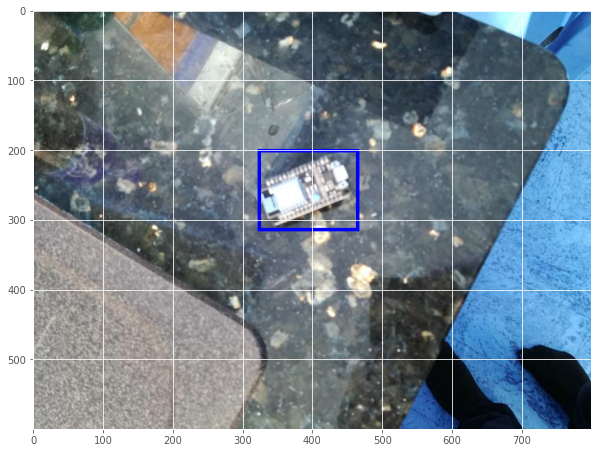

In [18]:
plt.figure(figsize=(10,10))
boxes=prediction[0].get('boxes')[:1]
colors = ["blue"]
result = draw_bounding_boxes(torch.tensor(img).permute(2,0,1), boxes, colors='blue',width=5)
plt.imshow(result.permute(1,2,0))

In [11]:
prediction[0]

{'boxes': tensor([[322.5136, 199.5350, 467.1553, 316.1080],
         [320.9181, 202.6153, 460.1158, 307.0587],
         [318.5653, 200.9161, 466.4154, 324.7668],
         [ 46.4694,   0.0000, 457.5431, 388.3477],
         [ 57.9896,   0.0000, 455.0412, 374.8499]], device='cuda:0'),
 'labels': tensor([2, 1, 4, 4, 3], device='cuda:0'),
 'scores': tensor([0.7388, 0.2959, 0.2590, 0.1431, 0.0543], device='cuda:0')}

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>